In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pickle
import topmed_manuscript_clean as tm
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects import conversion, default_converter
from adjustText import adjust_text
import pygenometracks.tracks as pygtk


def load_susieR_lbf_matrix(rda):
    df = None
    with conversion.localconverter(default_converter):
        pandas2ri.activate()
        base = importr('base')
        base.load(rda)
        tmp = robjects.r['susie_out']
        key_to_index = {k: i for i, k in enumerate(tmp.names)}

        lbf_variable = tmp[key_to_index['lbf_variable']]
        variants = robjects.r('colnames(susie_out$lbf_variable)')
        with (robjects.default_converter + pandas2ri.converter).context():
            df = robjects.conversion.get_conversion().rpy2py(lbf_variable)
            df = pd.DataFrame(df)
            df.columns = robjects.conversion.get_conversion().rpy2py(variants)
            df.index = [f'L{i}' for i in range(1, len(df)+1)]
    
    return df


def load_susieR_mu_matrix(rda):
    df = None
    with conversion.localconverter(default_converter):
        pandas2ri.activate()
        base = importr('base')
        base.load(rda)
        tmp = robjects.r['susie_out']
        key_to_index = {k: i for i, k in enumerate(tmp.names)}

        mu = tmp[key_to_index['mu']]
        variants = robjects.r('colnames(susie_out$lbf_variable)')
        with (robjects.default_converter + pandas2ri.converter).context():
            df = robjects.conversion.get_conversion().rpy2py(mu)
            df = pd.DataFrame(df)
            df.columns = robjects.conversion.get_conversion().rpy2py(variants)
            df.index = [f'L{i}' for i in range(1, len(df)+1)]
    
    return df


def load_susieR_signed_lbf_matrix(rda):
    unsigned_lbf = load_susieR_lbf_matrix(rda).T.rename_axis(index='variant_id')
    mu = load_susieR_mu_matrix(rda).T.rename_axis(index='variant_id')
    mu_sign = (mu / mu.abs())
    signed_lbf = unsigned_lbf * mu_sign
    return signed_lbf


def get_lbf_df(susie_gene_result):
    df = pd.DataFrame(susie_gene_result['lbf_variable'])
    df.index = susie_gene_result['sets']['purity'].index
    df.columns = susie_gene_result['pip'].index
    return df


def get_mu_df(susie_gene_result):
    df = pd.DataFrame(susie_gene_result['mu'])
    df.index = [f'L{i}' for i in range(1, len(df)+1)]
    df.columns = susie_gene_result['pip'].index
    return df

def get_signed_lbf_df(susie_gene_result):
    unsigned_lbf = get_lbf_df(susie_gene_result)
    mu = get_mu_df(susie_gene_result)
    return (np.sign(mu.loc[unsigned_lbf.index]) * unsigned_lbf)


def get_ukbb_ld_matrix_in_hg38(hg38_chrom, hg38_start, hg38_end):
    # get the hg19 region coordinates
    hg19_to_hg38 = pd.read_csv('/net/topmed11/working/porchard/panukbb-finemapping/work/ancestry-specific-finemapping/lift-susie/results/lifted-regions/regions-hg38.bed', sep='\t', header=None, names=['chrom', 'start', 'end', 'hg19'])
    gwas_region_hg19 = hg19_to_hg38[(hg19_to_hg38.chrom==hg38_chrom) & (hg19_to_hg38.start==int(hg38_start)) & (hg19_to_hg38.end==int(hg38_end))].hg19.values[0]

    # get the hg19 --> hg38 variant conversions
    snp_conversions = tm.tabix('/net/topmed11/working/porchard/panukbb-finemapping/work/lift/variants/results/conversion-table/snp-names.txt.gz', f'{hg38_chrom}:{hg38_start}-{hg38_end}').iloc[:,[6,7]]
    snp_conversions.columns = ['hg38', 'hg19']
    # remove any non one-to-one mappings
    snp_conversions = snp_conversions[~snp_conversions.hg19.duplicated(keep=False)]
    snp_conversions = snp_conversions[~snp_conversions.hg38.duplicated(keep=False)]
    hg19_to_hg38_variants = dict(zip(snp_conversions.hg19, snp_conversions.hg38))

    # get UKBB LD
    ukbb_ld = pd.read_csv('/net/topmed11/working/porchard/panukbb-finemapping/work/ancestry-specific-finemapping/ld-matrices/results/ld-matrix/{}___EUR.ld.tsv.bgz'.format(gwas_region_hg19.replace('chr', '').replace(':', '_')), sep='\t', header=None, compression='gzip', dtype=float)
    ukbb_ld_variants = pd.read_csv('/net/topmed11/working/porchard/panukbb-finemapping/work/ancestry-specific-finemapping/ld-matrices/results/ld-matrix/{}___EUR.variants.tsv.gz'.format(gwas_region_hg19.replace('chr', '').replace(':', '_')), sep='\t')
    ukbb_ld.columns = 'chr' + ukbb_ld_variants.variant_id.values
    ukbb_ld.index = 'chr' + ukbb_ld_variants.variant_id.values

    assert(ukbb_ld.columns.to_series().map(lambda x: x in hg19_to_hg38_variants).mean() >= 0.99)
    ukbb_ld = ukbb_ld.loc[ukbb_ld.index.to_series().map(lambda x: x in hg19_to_hg38_variants),ukbb_ld.columns.to_series().map(lambda x: x in hg19_to_hg38_variants)]
    ukbb_ld.columns = [hg19_to_hg38_variants[i] for i in ukbb_ld.columns]
    ukbb_ld.index = [hg19_to_hg38_variants[i] for i in ukbb_ld.index]

    # make symmetric
    ukbb_ld_symmetric = ukbb_ld + ukbb_ld.T
    for i in range(ukbb_ld_symmetric.shape[0]):
        ukbb_ld_symmetric.iat[i,i] /= 2

    return ukbb_ld_symmetric


def get_eqtl_nominal(file, region, gene):
    eqtl_nominal = tm.tabix(file, region)
    eqtl_nominal = eqtl_nominal.loc[eqtl_nominal.phenotype_id==gene,['variant_id', 'slope', 'negative_log10_p']]
    eqtl_nominal.slope = eqtl_nominal.slope.astype(float)
    eqtl_nominal.negative_log10_p = eqtl_nominal.negative_log10_p.astype(float)
    eqtl_nominal = eqtl_nominal.rename(columns={'slope': 'eqtl_slope', 'negative_log10_p': 'eqtl_negative_log10_p'})
    return eqtl_nominal


def get_gwas_nominal(file, region):
    gwas_nominal = tm.tabix(file, region)
    gwas_nominal['variant_id'] = gwas_nominal.chrom + '_' + gwas_nominal.end.astype(str) + '_' + gwas_nominal.ref + '_' + gwas_nominal.alt
    gwas_nominal = gwas_nominal[['variant_id', 'pval_EUR', 'beta_EUR', 'low_confidence_EUR']]
    gwas_nominal.pval_EUR = gwas_nominal.pval_EUR.astype(float)
    gwas_nominal.beta_EUR = gwas_nominal.beta_EUR.astype(float)
    gwas_nominal = gwas_nominal[~gwas_nominal.pval_EUR.isnull()]
    gwas_nominal = gwas_nominal[gwas_nominal.low_confidence_EUR=='False']
    gwas_nominal = gwas_nominal[['variant_id', 'pval_EUR', 'beta_EUR']].rename(columns={'pval_EUR': 'gwas_negative_log10_p', 'beta_EUR': 'gwas_slope'})
    gwas_nominal.gwas_negative_log10_p = gwas_nominal.gwas_negative_log10_p * -1
    return gwas_nominal


GTF = '../../manuscript-intermediate-processing/data/gtf/gencode.v30.GRCh38.ERCC.genes.collapsed_only.gtf.gz'
METADATA = '../../manuscript-intermediate-processing/data/metadata/metadata.tm.txt'
MANIFEST = '/net/topmed11/working/porchard/panukbb-finemapping/work/selected-traits/manifest.EUR.txt'
GENE_BED = '/net/topmed10/working/porchard/rnaseq/data/gtf/collapsed.names.bed'
COLOC = '../../manuscript-intermediate-processing/work/coloc/panukbb/joint/postprocessed.txt'
SUSIE_PICKLE = '../../manuscript-intermediate-processing/data/scan-results/joint-signed/cis-eqtl/susie/maf001/Whole_blood.100.susie.pickle'
SUSIE_GWAS = '/net/topmed11/working/porchard/panukbb-finemapping/work/ancestry-specific-finemapping/lift-susie/results/susie-cs-and-convergence/gwas.cs.txt'
SUSIE_QTL = '../../manuscript-intermediate-processing/data/scan-results/joint-signed/cis-eqtl/susie/maf001/Whole_blood.100.cs.txt'

gtf_df = tm.gtf_to_df(GTF, parse_attributes=['gene_id', 'gene_name'])
gtf_df = gtf_df[gtf_df.feature=='gene']
gene_id_to_gene_name = dict(zip(gtf_df.gene_id, gtf_df.gene_name))
gene_id_to_gene_chrom = dict(zip(gtf_df.gene_id, gtf_df.chrom))
gene_id_to_tss_pos = {gene_id: start if strand == '+' else end for gene_id, start, end, strand in zip(gtf_df.gene_id, gtf_df.start, gtf_df.end, gtf_df.strand)}
metadata = pd.read_csv(METADATA, sep='\t')

coloc = pd.read_csv(COLOC, sep='\t')

/net/snowwhite/home/porchard/anaconda3/envs/2020-09/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/net/snowwhite/home/porchard/anaconda3/envs/2020-09/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
track_config = dict(file=GENE_BED, arrow_length=1000, arrow_interval=10, file_type='bed', height=3, color='black', merge_transcripts=False, labels=True, section_name='', prefered_name='gene_name', global_max_row=False, fontstyle='italic', font_size=8
, style="UCSC", all_labels_inside=False, labels_in_margin=True)
tk = pygtk.BedTrack(track_config)

100%|██████████| 58103/58103 [00:02<00:00, 21157.38it/s]


In [3]:
manifest = pd.read_csv(MANIFEST, sep='\t')
trait_id_to_description = dict(zip(manifest.trait_id, manifest.description))

In [4]:
susie = dict()
with open(SUSIE_PICKLE, 'rb') as fh:
    susie.update(pickle.load(fh))

In [ ]:
# IL2R
# QTL_TISSUE = 'Whole_blood'
# QTL_MAF = '1%'
# QTL_GENE = 'ENSG00000134460.17'
# GWAS_TRAIT = 'continuous-AG-both_sexes-irnt'
# XMIN = 6042734
# XMAX = 6063965

# HK1
# QTL_TISSUE = 'Whole_blood'
# QTL_MAF = '1%'
# QTL_GENE = 'ENSG00000156515.23'
# GWAS_TRAIT = 'continuous-30040-both_sexes-irnt'
# XMIN = 69232284
# XMAX = 69395113

# CEBPB
QTL_TISSUE = 'Whole_blood'
QTL_MAF = '1%'
QTL_GENE = 'ENSG00000172216.5'
GWAS_TRAIT = 'continuous-30130-both_sexes-irnt'
XMIN = 50175000
XMAX = 50400000

QTL_MODALITY = 'cis-eQTL'

if 'sQTL' in QTL_MODALITY:
    raise ValueError('Cannot plot splicing examples')
if QTL_TISSUE != 'Whole_blood':
    raise ValueError('Can only plot whole blood examples')

GWAS_TRAIT_NAME = trait_id_to_description[GWAS_TRAIT]
QTL_GENE_NAME = gene_id_to_gene_name[QTL_GENE]
EQTL_NOMINAL = '../../manuscript-intermediate-processing/data/scan-results/joint/cis-eqtl/nominal/{}/{}.tsv.gz'.format('maf001' if QTL_MAF == '1%' else 'maf0001', QTL_TISSUE)
GWAS_NOMINAL = f'/net/topmed11/working/porchard/panukbb-finemapping/work/lift/gwas/results/lifted/{GWAS_TRAIT}.hg38.tsv.bgz'
MIN_ABS_LOG_LBF_TO_PLOT = 5
SIGN_ON_TRAIT_INCREASING = True


PREFIX = f'Fig4CDEF-{QTL_GENE_NAME}.'

In [6]:
coloc_subset = coloc[(coloc.xqtl_tissue==QTL_TISSUE) & (coloc.xqtl_maf==QTL_MAF) & (coloc.xqtl_modality.map(tm.format_modality)==QTL_MODALITY) & (coloc.xqtl_gene==QTL_GENE) & (coloc.gwas_trait==GWAS_TRAIT)]
if coloc_subset.gwas_region.nunique() > 1:
    raise ValueError('This example spans multiple GWAS regions; cannot plot') 
GWAS_REGION = coloc_subset.gwas_region.unique()[0]
coloc_subset.head()

,nsnps,hit1,hit2,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,idx1,idx2,...,xqtl_modality,xqtl_tissue,xqtl_maf,xqtl_phenotype,xqtl_ancestry,xqtl_gene,gwas_region,gwas_ancestry,gwas_trait,gwas_signal
4404,5992,chr20_50270731_C_T,chr20_50270731_C_T,2.248578e-197,1.299234e-180,4.184360e-20,0.000419,0.999581,5,1,...,ciseqtl,Whole_blood,1%,ENSG00000172216.5,joint,ENSG00000172216.5,chr20_49579246_51085543,EUR,continuous-30130-both_sexes-irnt,continuous-30130-both_sexes-irnt___EUR___chr20...
7260,5992,chr20_50339058_A_G,chr20_50338887_T_C,1.625919e-126,4.635508e-96,1.687467e-33,0.002817,0.997183,4,2,...,ciseqtl,Whole_blood,1%,ENSG00000172216.5,joint,ENSG00000172216.5,chr20_49579246_51085543,EUR,continuous-30130-both_sexes-irnt,continuous-30130-both_sexes-irnt___EUR___chr20...
9096,5992,chr20_50278382_C_T,chr20_50276198_C_A,8.570264e-37,2.261093e-25,2.761704e-14,0.005297,0.994703,3,3,...,ciseqtl,Whole_blood,1%,ENSG00000172216.5,joint,ENSG00000172216.5,chr20_49579246_51085543,EUR,continuous-30130-both_sexes-irnt,continuous-30130-both_sexes-irnt___EUR___chr20...
21440,5992,chr20_50276405_G_A,chr20_50276545_G_A,4.531714e-28,6.305562e-15,2.290100e-15,0.029925,0.970075,1,5,...,ciseqtl,Whole_blood,1%,ENSG00000172216.5,joint,ENSG00000172216.5,chr20_49579246_51085543,EUR,continuous-30130-both_sexes-irnt,continuous-30130-both_sexes-irnt___EUR___chr20...


In [7]:
GWAS_SUSIER_RDA = f'/net/topmed11/working/porchard/panukbb-finemapping/work/ancestry-specific-finemapping/lift-susie/results/susie-hg38/{GWAS_TRAIT}___EUR___{GWAS_REGION}.rda'
CHROM, START, END = GWAS_REGION.split('_')
TABIX_REGION = f'{CHROM}:{START}-{END}'

In [8]:
qtl_stats = get_signed_lbf_df(susie[QTL_GENE]).T
qtl_stats = qtl_stats.reset_index()
qtl_stats.head()

,variant_id,L5,L3,L4,L1,L2
0,chr20_49191432_C_T,1.755399,1.957299,1.864164,2.307547,2.023940
1,chr20_49191508_A_AG,-2.109462,2.081529,2.130801,2.528925,-2.296981
2,chr20_49191533_G_A,-0.606048,0.561047,-0.356345,1.354801,-0.753262
3,chr20_49192164_G_A,1.938244,2.105042,1.946754,2.498772,1.900109
4,chr20_49193152_G_A,-0.781513,-0.448978,-0.669067,-0.114943,-0.868232


In [9]:
gwas_stats = load_susieR_signed_lbf_matrix(GWAS_SUSIER_RDA)
gwas_stats = gwas_stats.reset_index()
gwas_stats.head()

/net/snowwhite/home/porchard/anaconda3/envs/2020-09/lib/python3.8/site-packages/rpy2/robjects/vectors.py:1016: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/net/snowwhite/home/porchard/anaconda3/envs/2020-09/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:2211: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  values, tz_parsed = conversion.datetime_to_datetime64(data.ravel("K"))


,variant_id,L1,L2,L3,L4,L5,L6,L7,L8,L9,...,L11,L12,L13,L14,L15,L16,L17,L18,L19,L20
0,chr20_49579515_T_C,3.326632,3.032466,2.417227,-1.768733,-2.182991,-1.924512,-1.671195,-1.917470,-1.851528,...,-0.992473,-0.994696,-0.996226,-0.996476,-0.995735,-0.994552,-0.993328,-0.992253,-0.991368,-0.990645
1,chr20_49579519_A_C,3.118835,2.952721,2.212720,1.692907,2.016585,1.802828,1.547027,1.775854,1.786356,...,0.884880,0.886942,0.888354,0.888569,0.887856,0.886733,0.885580,0.884574,0.883759,0.883104
2,chr20_49579853_C_G,-3.173954,-3.038277,-2.317300,-1.632349,-2.045289,-1.858185,-1.569960,-1.845103,-1.774835,...,-0.904660,-0.906753,-0.908157,-0.908329,-0.907565,-0.906406,-0.905241,-0.904241,-0.903433,-0.902773
3,chr20_49579879_G_T,-3.310175,-3.036630,-2.381265,-1.799880,-2.144316,-1.905291,-1.663179,-1.909309,-1.893672,...,-0.985742,-0.987887,-0.989352,-0.989570,-0.988825,-0.987656,-0.986456,-0.985412,-0.984563,-0.983879
4,chr20_49579997_C_T,-2.932020,-2.838566,-2.028156,-1.451522,-1.755707,-1.560798,-1.316397,-1.535297,-1.574316,...,-0.672505,-0.674507,-0.675880,-0.676097,-0.675417,-0.674337,-0.673222,-0.672245,-0.671448,-0.670804


In [10]:
ukbb_ld = get_ukbb_ld_matrix_in_hg38(CHROM, START, END)
ukbb_ld.head()

,chr20_49579515_T_C,chr20_49579519_A_C,chr20_49579853_C_G,chr20_49579879_G_T,chr20_49579997_C_T,chr20_49580038_C_G,chr20_49580202_G_A,chr20_49580212_G_A,chr20_49580405_A_G,chr20_49580425_G_A,...,chr20_51083738_G_A,chr20_51084009_T_C,chr20_51084166_G_A,chr20_51084448_G_A,chr20_51084458_C_A,chr20_51084728_C_T,chr20_51084729_G_A,chr20_51084865_A_G,chr20_51085149_T_C,chr20_51085320_A_AT
chr20_49579515_T_C,0.999951,-0.003968,-0.013986,-0.000797,-0.004135,0.026167,-0.002695,-0.003128,-0.003308,0.426788,...,0.010742,0.009718,0.003279,-0.001964,-0.002335,-0.000638,-0.003230,-0.004734,-0.003371,-0.000198
chr20_49579519_A_C,-0.003968,0.999977,-0.000882,-0.000334,0.001557,0.003553,-0.000356,-0.000464,0.000123,0.033518,...,-0.000936,-0.001521,-0.000560,-0.001082,-0.000809,-0.000824,0.005450,0.002404,0.003400,-0.000772
chr20_49579853_C_G,-0.013986,-0.000882,0.999946,-0.000870,0.000071,0.005032,-0.000692,-0.000976,-0.001184,-0.032462,...,-0.004356,-0.006593,-0.001341,-0.002521,-0.000793,-0.000831,-0.000641,0.000415,-0.001716,0.000509
chr20_49579879_G_T,-0.000797,-0.000334,-0.000870,0.999928,0.008615,0.001460,0.012709,0.019045,0.013168,-0.003730,...,-0.001233,-0.001176,0.042730,-0.000204,-0.000246,-0.000336,-0.000280,-0.000858,-0.000257,0.002140
chr20_49579997_C_T,-0.004135,0.001557,0.000071,0.008615,0.999966,0.001801,0.000993,0.004744,0.617535,-0.006526,...,-0.003449,-0.004027,0.047426,0.000406,-0.000671,-0.000613,-0.000736,0.002189,-0.000394,-0.000385


In [11]:
eqtl_nominal = get_eqtl_nominal(EQTL_NOMINAL, TABIX_REGION, QTL_GENE)
eqtl_nominal.head()

,variant_id,eqtl_slope,eqtl_negative_log10_p
10,chr20_49579515_T_C,-0.026899,0.335748
39,chr20_49579879_G_T,-0.061569,0.313659
68,chr20_49579997_C_T,-0.077493,0.897632
97,chr20_49580405_A_G,-0.064492,0.616759
126,chr20_49580425_G_A,-0.011459,0.258437


In [12]:
gwas_nominal = get_gwas_nominal(GWAS_NOMINAL, TABIX_REGION)

In [13]:
qtl_stats = qtl_stats[qtl_stats.variant_id.isin(set(gwas_stats.variant_id))]
gwas_stats = gwas_stats[gwas_stats.variant_id.isin(set(qtl_stats.variant_id))]
lbf = qtl_stats.set_index('variant_id').rename(columns=lambda x: 'qtl_' + x).join(
    gwas_stats.set_index('variant_id').rename(columns=lambda x: 'gwas_' + x)
)
lbf = lbf.astype(float)
lbf.head()

,qtl_L5,qtl_L3,qtl_L4,qtl_L1,qtl_L2,gwas_L1,gwas_L2,gwas_L3,gwas_L4,gwas_L5,...,gwas_L11,gwas_L12,gwas_L13,gwas_L14,gwas_L15,gwas_L16,gwas_L17,gwas_L18,gwas_L19,gwas_L20
variant_id,,,,,,,,,,,,,,,,,,,,,
chr20_49579515_T_C,2.175950,2.058938,2.096415,2.291513,2.235700,3.326632,3.032466,2.417227,-1.768733,-2.182991,...,-0.992473,-0.994696,-0.996226,-0.996476,-0.995735,-0.994552,-0.993328,-0.992253,-0.991368,-0.990645
chr20_49579879_G_T,-2.195503,2.046381,2.128438,2.383690,-2.305347,-3.310175,-3.036630,-2.381265,-1.799880,-2.144316,...,-0.985742,-0.987887,-0.989352,-0.989570,-0.988825,-0.987656,-0.986456,-0.985412,-0.984563,-0.983879
chr20_49579997_C_T,-2.154739,1.652988,2.003560,1.932993,-2.303644,-2.932020,-2.838566,-2.028156,-1.451522,-1.755707,...,-0.672505,-0.674507,-0.675880,-0.676097,-0.675417,-0.674337,-0.673222,-0.672245,-0.671448,-0.670804
chr20_49580405_A_G,-2.041989,1.913007,2.014107,2.128283,-2.294692,-2.477467,-2.369038,-1.549468,-0.978369,-1.222299,...,-0.266039,-0.267794,-0.268990,-0.269166,-0.268555,-0.267598,-0.266615,-0.265758,-0.265064,-0.264508
chr20_49580425_G_A,2.213903,2.130833,-2.149801,2.523658,-2.275956,3.368191,3.047148,-2.387125,-1.803349,-2.176999,...,-1.001486,-1.003738,-1.005304,-1.005583,-1.004854,-1.003666,-1.002423,-1.001322,-1.000416,-0.999682


In [14]:
qtl_stats['pos'] = qtl_stats.variant_id.str.split('_', expand=True)[1].astype(int)
gwas_stats['pos'] = gwas_stats.variant_id.str.split('_', expand=True)[1].astype(int)
lbf['pos'] = lbf.index.to_series().str.split('_', expand=True)[1].astype(int)

In [15]:
susie_qtl = pd.read_csv(SUSIE_QTL, sep='\t')
susie_qtl = susie_qtl[susie_qtl.phenotype_id==QTL_GENE]
susie_qtl = susie_qtl[susie_qtl.cs_id.isin(coloc_subset.xqtl_cs.str.replace('L', '').astype(int))]
susie_qtl

,phenotype_id,variant_id,pip,af,cs_id
397509,ENSG00000172216.5,chr20_50338887_T_C,0.415423,0.498760,1
397510,ENSG00000172216.5,chr20_50339058_A_G,0.566029,0.511543,1
397511,ENSG00000172216.5,chr20_50267587_C_A,0.171856,0.148358,2
397512,ENSG00000172216.5,chr20_50270731_C_T,0.826875,0.144871,2
397514,ENSG00000172216.5,chr20_50276198_C_A,0.362755,0.232491,4
397515,ENSG00000172216.5,chr20_50277887_A_C,0.038368,0.237295,4
397516,ENSG00000172216.5,chr20_50278382_C_T,0.586474,0.232569,4
397517,ENSG00000172216.5,chr20_50276405_G_A,0.999999,0.094283,5


In [16]:
susie_gwas = pd.read_csv(SUSIE_GWAS, sep='\t', header=None, names=['variant_id', 'cs_id', 'pip', 'signal'])
susie_gwas = susie_gwas[susie_gwas.signal==f'{GWAS_TRAIT}___EUR___{GWAS_REGION}']
susie_gwas = susie_gwas[susie_gwas.cs_id.isin(coloc_subset.gwas_cs)]
susie_gwas

,variant_id,cs_id,pip,signal
756866,chr20_50270731_C_T,L1,1.000000,continuous-30130-both_sexes-irnt___EUR___chr20...
756867,chr20_50338887_T_C,L2,0.995052,continuous-30130-both_sexes-irnt___EUR___chr20...
756871,chr20_50276198_C_A,L3,0.725383,continuous-30130-both_sexes-irnt___EUR___chr20...
756872,chr20_50277887_A_C,L3,0.124045,continuous-30130-both_sexes-irnt___EUR___chr20...
756873,chr20_50277933_C_G,L3,0.115380,continuous-30130-both_sexes-irnt___EUR___chr20...
756874,chr20_50276405_G_A,L5,0.060886,continuous-30130-both_sexes-irnt___EUR___chr20...
756875,chr20_50276545_G_A,L5,0.938337,continuous-30130-both_sexes-irnt___EUR___chr20...


In [17]:
eqtl_or_gwas_cs_variants = susie_qtl.variant_id.to_list() + susie_gwas.variant_id.to_list()
eqtl_or_gwas_cs_variants = [int(i.split('_')[1]) for i in eqtl_or_gwas_cs_variants]
if XMIN is None:
    EXTENSION = 10000
    XMIN = min(eqtl_or_gwas_cs_variants) - EXTENSION
if XMAX is None:
    EXTENSION = 10000
    XMAX = max(eqtl_or_gwas_cs_variants) + EXTENSION

In [18]:
susie_qtl[['variant_id', 'pip', 'cs_id']].rename(columns={'pip': 'qtl_pip', 'cs_id': 'qtl_cs_id'}).merge(
    susie_gwas[['variant_id', 'pip', 'cs_id']].rename(columns={'pip': 'gwas_pip', 'cs_id': 'gwas_cs_id'}),
    how='outer'
)

,variant_id,qtl_pip,qtl_cs_id,gwas_pip,gwas_cs_id
0,chr20_50338887_T_C,0.415423,1.0,0.995052,L2
1,chr20_50339058_A_G,0.566029,1.0,NaN,NaN
2,chr20_50267587_C_A,0.171856,2.0,NaN,NaN
3,chr20_50270731_C_T,0.826875,2.0,1.000000,L1
4,chr20_50276198_C_A,0.362755,4.0,0.725383,L3
5,chr20_50277887_A_C,0.038368,4.0,0.124045,L3
6,chr20_50278382_C_T,0.586474,4.0,NaN,NaN
7,chr20_50276405_G_A,0.999999,5.0,0.060886,L5
8,chr20_50277933_C_G,NaN,NaN,0.115380,L3
9,chr20_50276545_G_A,NaN,NaN,0.938337,L5


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 5.68,-0.08
<ipython-input-19-052d71ab15c1>:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


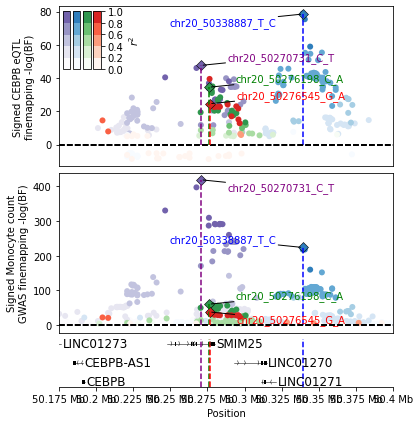

In [19]:
fig, axs = plt.subplots(nrows=3, figsize=(6, 7), gridspec_kw=dict(height_ratios=[1,1,0.3], hspace=0.05))


# select a color for each effect

palettes = ['Purples', 'Blues', 'Greens', 'Reds']
NORMALIZE_LBF = False
gwas_texts = []
qtl_texts = []

for i, (j, row) in enumerate(coloc_subset.iterrows()):
    
    cmap = cm.get_cmap(palettes[i])
    bounds = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    cmap = tm.truncate_colormap(cmap, 0, 0.7, n=cmap.N)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    lead_variant_marker =  {'marker': 'D', 'color': cmap(norm(1.0)), 'edgecolor': 'black', 's': 50}

    gwas_cs = row['gwas_cs']
    qtl_cs = row['xqtl_cs']
    pp4 = round(row['PP.H4.abf'], 3)
    LEAD_GWAS_VARIANT = lbf[f'gwas_{gwas_cs}'].abs().sort_values(ascending=False).index[0]
    lead_variant_pos = int(LEAD_GWAS_VARIANT.split('_')[1])
    ld_with_lead_variant = ukbb_ld.loc[LEAD_GWAS_VARIANT].abs().to_dict()
    lbf['ld_with_gwas_lead_variant'] = lbf.index.map(ld_with_lead_variant)
    lbf = lbf.sort_values('ld_with_gwas_lead_variant', ascending=True)

    kwargs = {'hue': 'ld_with_gwas_lead_variant', 'palette': cmap, 'hue_norm': norm, 'legend': True, 'edgecolor': 'None', 'legend': False}
    df = lbf.copy()
    if NORMALIZE_LBF:
        df[f'gwas_{gwas_cs}'] = df[f'gwas_{gwas_cs}'] / df[f'gwas_{gwas_cs}'].abs().max()
        df[f'qtl_{qtl_cs}'] = df[f'qtl_{qtl_cs}'] / df[f'qtl_{qtl_cs}'].abs().max()
    if SIGN_ON_TRAIT_INCREASING:
        df[f'qtl_{qtl_cs}'] = df[f'qtl_{qtl_cs}'] * np.sign(df[f'gwas_{gwas_cs}'])
        df[f'gwas_{gwas_cs}'] = df[f'gwas_{gwas_cs}'].abs()
        #df[f'qtl_{qtl_cs}'] = df[f'qtl_{qtl_cs}'].abs()

    ax = axs[1]
    ax.axhline(0, color='black', linestyle='--')
    sns.scatterplot(x='pos', y=f'gwas_{gwas_cs}', data=df[(df.index!=LEAD_GWAS_VARIANT) & (df[f'gwas_{gwas_cs}'].abs() >= MIN_ABS_LOG_LBF_TO_PLOT)], ax=ax, **kwargs)
    sns.scatterplot(x='pos', y=f'gwas_{gwas_cs}', data=df.loc[[LEAD_GWAS_VARIANT]], ax=ax, legend=False, **lead_variant_marker)
    lead_variant_stat = df.at[LEAD_GWAS_VARIANT,f'gwas_{gwas_cs}']
    ax.plot([lead_variant_pos, lead_variant_pos], [0, lead_variant_stat], color=palettes[i].rstrip('s').lower(), linestyle='--')
    ax.set_xlabel('')
    ax.set_ylabel(f'Signed {GWAS_TRAIT_NAME}\nGWAS finemapping -log(BF)')
    ax.set_xlim(XMIN, XMAX)
    ax.set_xticks([])
    gwas_texts += [ax.text(row['pos'], row[f'gwas_{gwas_cs}'], LEAD_GWAS_VARIANT, color=palettes[i].lower().rstrip('s')) for j, row in df.loc[[LEAD_GWAS_VARIANT]].iterrows()]

    ax = axs[0]
    ax.axhline(0, color='black', linestyle='--')
    sns.scatterplot(x='pos', y=f'qtl_{qtl_cs}', data=df[(df.index!=LEAD_GWAS_VARIANT) & (df[f'qtl_{qtl_cs}'].abs() >= MIN_ABS_LOG_LBF_TO_PLOT)], ax=ax, **kwargs)
    sns.scatterplot(x='pos', y=f'qtl_{qtl_cs}', data=df.loc[[LEAD_GWAS_VARIANT]], ax=ax, legend=False, **lead_variant_marker)
    lead_variant_stat = df.at[LEAD_GWAS_VARIANT,f'qtl_{qtl_cs}']
    ax.plot([lead_variant_pos, lead_variant_pos], [0, lead_variant_stat], color=palettes[i].rstrip('s').lower(), linestyle='--')
    ax.set_xlabel('')
    ax.set_ylabel(f'Signed {QTL_GENE_NAME} eQTL\nfinemapping -log(BF)')
    ax.set_xlim(XMIN, XMAX)
    ax.set_xticks([])
    qtl_texts += [ax.text(row['pos'], row[f'qtl_{qtl_cs}'], LEAD_GWAS_VARIANT, color=palettes[i].lower().rstrip('s')) for j, row in df.loc[[LEAD_GWAS_VARIANT]].iterrows()]
    if QTL_GENE == 'ENSG00000172216.5': # CEBPB
        cax = inset_axes(ax, width=0.1, height=0.8, bbox_to_anchor=(0.05+0.03*i,1), bbox_transform=ax.transAxes)
    elif QTL_GENE == 'ENSG00000134460.17' or QTL_GENE == 'ENSG00000156515.23': # IL2R, HK1
        cax = inset_axes(ax, width=0.1, height=0.8, bbox_to_anchor=(0.05+0.03*i,0.5), bbox_transform=ax.transAxes)
    else:
        cax = inset_axes(ax, width=0.1, height=0.8, bbox_to_anchor=(0.05+0.03*i,1), bbox_transform=ax.transAxes)
    if i == len(coloc_subset) - 1:
        fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical', label='$r^2$')
    else:
        cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical', label='')
        cbar.set_ticks([])

    ax = axs[2]
    ax.axvline(lead_variant_pos, color=palettes[i].rstrip('s').lower(), linestyle='--')

# gene model
ax = axs[2]
XLIMS = [XMIN, XMAX]
# ax.axvline(lead_variant_pos, color=palettes[i].rstrip('s').lower(), linestyle='--')
ax.set_xlim(XLIMS)
tk.plot(ax, CHROM, XMIN, XMAX)
if QTL_GENE == 'ENSG00000134460.17': # IL2R
    ax.set_xticks([6045000, 6050000, 6055000, 6060000])
elif QTL_GENE == 'ENSG00000156515.23': # HK1
    ax.set_xticks([69240000, 69270000, 69300000, 69330000, 69360000, 69390000])
ax.xaxis.set_major_formatter(tm.pos_formatter)
ax.set_xlabel('Position')
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()
adjust_text(gwas_texts, ax=axs[1], arrowprops=dict(arrowstyle='-', color='black'), force_points=0.5, force_text=0.1, expand_points=(1.5, 1.5))
adjust_text(qtl_texts, ax=axs[0], arrowprops=dict(arrowstyle='-', color='black'), force_points=0.5, force_text=0.1, expand_points=(1.5, 1.5))
fig.savefig(f'figures/{PREFIX}png', dpi=300, facecolor='white', bbox_inches='tight')

In [20]:
lead_gwas_variants = []
for gwas_cs in coloc_subset.gwas_cs.to_list():
    lead_gwas_variants.append(lbf[f'gwas_{gwas_cs}'].abs().sort_values(ascending=False).index[0])
lead_gwas_variants

['chr20_50270731_C_T',
 'chr20_50338887_T_C',
 'chr20_50276198_C_A',
 'chr20_50276545_G_A']

In [21]:
LEAD_GWAS_VARIANT = gwas_nominal.sort_values('gwas_negative_log10_p', ascending=False).variant_id.values[0]
LEAD_GWAS_VARIANT

'chr20_50270731_C_T'

In [22]:
both_nominal = eqtl_nominal.merge(gwas_nominal, on='variant_id', how='inner').set_index('variant_id')
both_nominal['pos'] = both_nominal.index.to_series().str.split('_', expand=True)[1].astype(int)
ld_with_lead_variant = ukbb_ld.loc[LEAD_GWAS_VARIANT].abs().to_dict()
both_nominal['ld_with_gwas_lead_variant'] = both_nominal.index.map(ld_with_lead_variant)
both_nominal = both_nominal.sort_values('ld_with_gwas_lead_variant', ascending=True)
both_nominal.head()

,eqtl_slope,eqtl_negative_log10_p,gwas_negative_log10_p,gwas_slope,pos,ld_with_gwas_lead_variant
variant_id,,,,,,
chr20_49682654_G_A,-0.020761,0.109224,6.7680,-0.02994,49682654,2.684148e-07
chr20_50344686_C_T,-0.226750,25.859281,91.7400,-0.04192,50344686,6.843071e-06
chr20_50440514_T_C,-0.016624,0.097611,0.7896,-0.11270,50440514,2.172235e-05
chr20_50976511_A_G,-0.025131,0.289621,0.9559,-0.02157,50976511,3.234871e-05
chr20_50632948_G_A,-0.025023,0.199842,0.9631,0.08000,50632948,3.840192e-05


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 5.68,-0.08
<ipython-input-23-972f7564adbb>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


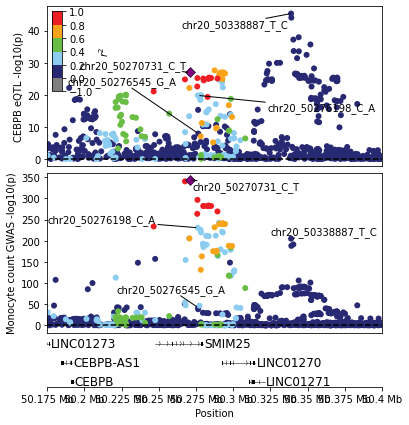

In [23]:
fig, axs = plt.subplots(nrows=3, figsize=(6, 7), gridspec_kw=dict(height_ratios=[1,1,0.3], hspace=0.05))

gwas_texts = []
qtl_texts = []

lz_colors = ["#7F7F7F", "#282973", "#8CCCF0", "#69BD45", "#F9A41A", "#ED1F24"] # LD coloring, from low (inc. < 0; grey) to high (red)
lead_variant_marker =  {'marker': 'D', 'color': 'purple', 'edgecolor': 'black'}
cmap = mpl.colors.ListedColormap(lz_colors)
bounds = np.append(-1, np.arange(0,1.2,0.2))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

lead_variant_marker =  {'marker': 'D', 'color': 'purple', 'edgecolor': 'black', 's': 50}
kwargs = {'hue': 'ld_with_gwas_lead_variant', 'palette': cmap, 'hue_norm': norm, 'legend': True, 'edgecolor': 'None', 'legend': False}

df = both_nominal.copy()

ax = axs[1]
ax.axhline(0, color='black', linestyle='--')
sns.scatterplot(x='pos', y=f'gwas_negative_log10_p', data=df[(df.index!=LEAD_GWAS_VARIANT)], ax=ax, **kwargs)
sns.scatterplot(x='pos', y=f'gwas_negative_log10_p', data=df.loc[[LEAD_GWAS_VARIANT]], ax=ax, legend=False, **lead_variant_marker)
ax.set_xlabel('')
ax.set_ylabel(f'{GWAS_TRAIT_NAME} GWAS -log10(p)')
ax.set_xlim(XMIN, XMAX)
ax.xaxis.set_major_formatter(tm.pos_formatter)
ax.set_xticks([])
gwas_texts = [ax.text(df.at[variant,'pos'], df.at[variant,'gwas_negative_log10_p'], variant) for variant in lead_gwas_variants]

ax = axs[0]
ax.axhline(0, color='black', linestyle='--')
sns.scatterplot(x='pos', y=f'eqtl_negative_log10_p', data=df[(df.index!=LEAD_GWAS_VARIANT)], ax=ax, **kwargs)
sns.scatterplot(x='pos', y=f'eqtl_negative_log10_p', data=df.loc[[LEAD_GWAS_VARIANT]], ax=ax, legend=False, **lead_variant_marker)
ax.set_xlabel('')
ax.set_ylabel(f'{QTL_GENE_NAME} eQTL -log10(p)')
ax.set_xlim(XMIN, XMAX)
ax.xaxis.set_major_formatter(tm.pos_formatter)
ax.set_xticks([])
qtl_texts = [ax.text(df.at[variant,'pos'], df.at[variant,'eqtl_negative_log10_p'], variant) for variant in lead_gwas_variants]
cax = inset_axes(ax, width="3%", height="50%", loc='upper left')
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical', label='$r^2$')


# gene model
ax = axs[2]
XLIMS = [XMIN, XMAX]
ax.set_xlim(XLIMS)
tk.plot(ax, CHROM, XMIN, XMAX)
if QTL_GENE == 'ENSG00000134460.17': # IL2R
    ax.set_xticks([6045000, 6050000, 6055000, 6060000])
elif QTL_GENE == 'ENSG00000156515.23': # HK1
    ax.set_xticks([69240000, 69270000, 69300000, 69330000, 69360000, 69390000])
ax.xaxis.set_major_formatter(tm.pos_formatter)
ax.set_xlabel('Position')
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()


adjust_text(gwas_texts, ax=axs[1], arrowprops=dict(arrowstyle='-', color='black'), x=df.pos.to_list(), y=df.gwas_negative_log10_p.to_list())
adjust_text(qtl_texts, ax=axs[0], arrowprops=dict(arrowstyle='-', color='black'), x=df.pos.to_list(), y=df.eqtl_negative_log10_p.to_list())

fig.savefig(f'figures/{PREFIX}marginal.png', dpi=300, facecolor='white', bbox_inches='tight')

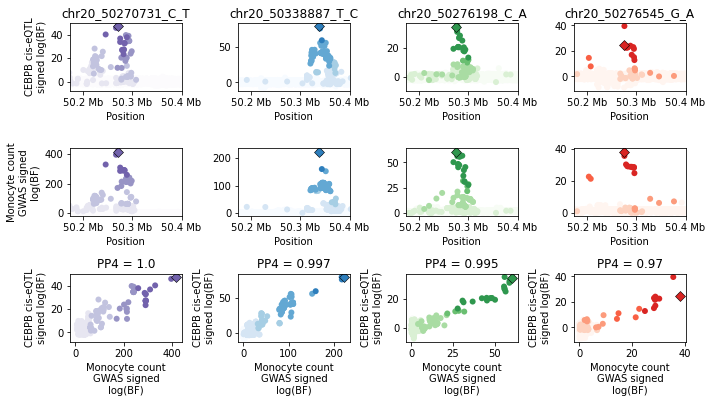

In [25]:
ncols = len(coloc_subset)
nrows = 3

fig, axs = plt.subplots(nrows=3, ncols=ncols, figsize=(ncols*2.5, nrows*1.9), squeeze=True)

for i, (j, row) in enumerate(coloc_subset.iterrows()):
    gwas_cs = row['gwas_cs']
    qtl_cs = row['xqtl_cs']
    pp4 = round(row['PP.H4.abf'], 3)
    LEAD_GWAS_VARIANT = lbf[f'gwas_{gwas_cs}'].abs().sort_values(ascending=False).index[0]
    LEAD_QTL_VARIANT = lbf[f'qtl_{qtl_cs}'].abs().sort_values(ascending=False).index[0]
    ld_with_lead_variant = ukbb_ld.loc[LEAD_GWAS_VARIANT].abs().to_dict()
    lbf['ld_with_lead_variant'] = lbf.index.map(ld_with_lead_variant)
    lbf = lbf.sort_values('ld_with_lead_variant', ascending=True)

    cmap = cm.get_cmap(palettes[i])
    bounds = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    cmap = tm.truncate_colormap(cmap, 0, 0.7, n=cmap.N)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    lead_variant_marker =  {'marker': 'D', 'color': cmap(norm(1.0)), 'edgecolor': 'black', 's': 50}
    kwargs = {'hue': 'ld_with_lead_variant', 'palette': cmap, 'hue_norm': norm, 'legend': False, 'edgecolor': 'None'}


    df = lbf.copy()
    if NORMALIZE_LBF:
        df[f'gwas_{gwas_cs}'] = df[f'gwas_{gwas_cs}'] / df[f'gwas_{gwas_cs}'].abs().max()
        df[f'qtl_{qtl_cs}'] = df[f'qtl_{qtl_cs}'] / df[f'qtl_{qtl_cs}'].abs().max()
    if SIGN_ON_TRAIT_INCREASING:
        df[f'qtl_{qtl_cs}'] = df[f'qtl_{qtl_cs}'] * np.sign(df[f'gwas_{gwas_cs}'])
        df[f'gwas_{gwas_cs}'] = df[f'gwas_{gwas_cs}'].abs()
        #df[f'qtl_{qtl_cs}'] = df[f'qtl_{qtl_cs}'].abs()

    ax = axs[1,i]
    sns.scatterplot(x='pos', y=f'gwas_{gwas_cs}', data=df, ax=ax, **kwargs)
    sns.scatterplot(x='pos', y=f'gwas_{gwas_cs}', data=df.loc[[LEAD_GWAS_VARIANT]], ax=ax, legend=False, **lead_variant_marker)
    ax.set_xlabel('Position')
    if QTL_GENE == 'ENSG00000156515.23':
        ax.set_xticks([69250000, 69350000])
    ax.xaxis.set_major_formatter(tm.pos_formatter)
    if ax.is_first_col():
        ax.set_ylabel(f'{GWAS_TRAIT_NAME}\nGWAS signed\nlog(BF)')
    else:
        #ax.set_ylabel(f'signed\nlog(BF) {gwas_cs}')
        ax.set_ylabel('')
    ax.set_xlim(XMIN, XMAX)
    #ax.set_title('Coloc. {}'.format(i+1))

    ax = axs[0,i]
    sns.scatterplot(x='pos', y=f'qtl_{qtl_cs}', data=df, ax=ax, **kwargs)
    sns.scatterplot(x='pos', y=f'qtl_{qtl_cs}', data=df.loc[[LEAD_GWAS_VARIANT]], ax=ax, legend=False, **lead_variant_marker)
    ax.set_xlabel('Position')
    if QTL_GENE == 'ENSG00000156515.23':
        ax.set_xticks([69250000, 69350000])
    ax.xaxis.set_major_formatter(tm.pos_formatter)
    if ax.is_first_col():
        ax.set_ylabel(f'{QTL_GENE_NAME} {QTL_MODALITY}\nsigned log(BF)')
    else:
        ax.set_ylabel('')
    ax.set_xlim(XMIN, XMAX)
    ax.set_title(LEAD_GWAS_VARIANT)

    ax = axs[2,i]
    sns.scatterplot(x=f'gwas_{gwas_cs}', y=f'qtl_{qtl_cs}', data=df, ax=ax, **kwargs)
    sns.scatterplot(x=f'gwas_{gwas_cs}', y=f'qtl_{qtl_cs}', data=df.loc[[LEAD_GWAS_VARIANT]], ax=ax, legend=False, **lead_variant_marker)
    ax.set_title(f'PP4 = {pp4}')
    ax.set_xlabel(f'{GWAS_TRAIT_NAME}\nGWAS signed\nlog(BF)')
    ax.set_ylabel(f'{QTL_GENE_NAME} {QTL_MODALITY}\nsigned log(BF)')
fig.tight_layout()
fig.savefig(f'figures/{PREFIX}locuszoom.png', dpi=300, facecolor='white', bbox_inches='tight')